# ***Machine Learning model selection***

## 📚 ***Import libraries***

In [1]:
# base libraries for data science
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer

# models
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import (
    KFold,
    ShuffleSplit,
    cross_val_score,
    learning_curve,
    train_test_split,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

## 💾 ***Load data***

In [2]:
DATA_DIR = Path.cwd().resolve().parents[1] / "data"
covid_df = pd.read_parquet(DATA_DIR / "02_intermediate/covid_type_fixed.parquet", engine="pyarrow")

In [3]:
columnas_df = [
    "CASE_COUNT",
    "PROBABLE_CASE_COUNT",
    "HOSPITALIZED_COUNT",
    "DEATH_COUNT",
    "CASE_COUNT_7DAY_AVG",
    "ALL_CASE_COUNT_7DAY_AVG",
    "HOSP_COUNT_7DAY_AVG",
    "DEATH_COUNT_7DAY_AVG",
]
covid_df = covid_df[columnas_df].copy()

In [4]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1915 entries, 0 to 1914
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   CASE_COUNT               1915 non-null   int64
 1   PROBABLE_CASE_COUNT      1915 non-null   int64
 2   HOSPITALIZED_COUNT       1915 non-null   int64
 3   DEATH_COUNT              1915 non-null   int64
 4   CASE_COUNT_7DAY_AVG      1915 non-null   int64
 5   ALL_CASE_COUNT_7DAY_AVG  1915 non-null   int64
 6   HOSP_COUNT_7DAY_AVG      1915 non-null   int64
 7   DEATH_COUNT_7DAY_AVG     1915 non-null   int64
dtypes: int64(8)
memory usage: 119.8 KB


In [5]:
numeric_features = [
    "CASE_COUNT",
    "PROBABLE_CASE_COUNT",
    "HOSPITALIZED_COUNT",
    "CASE_COUNT_7DAY_AVG",
    "ALL_CASE_COUNT_7DAY_AVG",
    "HOSP_COUNT_7DAY_AVG",
    "DEATH_COUNT_7DAY_AVG",
]

In [6]:
numeric_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipe, numeric_features),
    ]
)

In [7]:
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['CASE_COUNT', 'PROBABLE_CASE_COUNT',
                                  'HOSPITALIZED_COUNT', 'CASE_COUNT_7DAY_AVG',
                                  'ALL_CASE_COUNT_7DAY_AVG',
                                  'HOSP_COUNT_7DAY_AVG',
                                  'DEATH_COUNT_7DAY_AVG'])])

***Train / Test split***

In [8]:
X_features = covid_df.drop("DEATH_COUNT", axis="columns")
Y_target = covid_df["DEATH_COUNT"]

# 80% train, 20% test
x_train, x_test, y_train, y_test = train_test_split(
    X_features, Y_target, test_size=0.2, random_state=42
)

In [9]:
x_train.shape, y_train.shape

((1532, 7), (1532,))

In [10]:
x_test.shape, y_test.shape

((383, 7), (383,))

***Example of the data preprocessing pipeline***

In [11]:
preprocessor.fit(x_train)

feature_names = preprocessor.get_feature_names_out()

x_test_transformed = preprocessor.transform(x_test)
x_test_transformed = pd.DataFrame(x_test_transformed, columns=feature_names)
x_test_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   numeric__CASE_COUNT               383 non-null    float64
 1   numeric__PROBABLE_CASE_COUNT      383 non-null    float64
 2   numeric__HOSPITALIZED_COUNT       383 non-null    float64
 3   numeric__CASE_COUNT_7DAY_AVG      383 non-null    float64
 4   numeric__ALL_CASE_COUNT_7DAY_AVG  383 non-null    float64
 5   numeric__HOSP_COUNT_7DAY_AVG      383 non-null    float64
 6   numeric__DEATH_COUNT_7DAY_AVG     383 non-null    float64
dtypes: float64(7)
memory usage: 21.1 KB


In [12]:
x_test_transformed.sample(5)

,numeric__CASE_COUNT,numeric__PROBABLE_CASE_COUNT,numeric__HOSPITALIZED_COUNT,numeric__CASE_COUNT_7DAY_AVG,numeric__ALL_CASE_COUNT_7DAY_AVG,numeric__HOSP_COUNT_7DAY_AVG,numeric__DEATH_COUNT_7DAY_AVG
15,953.0,329.0,64.0,665.0,895.0,54.0,8.0
74,1264.0,406.0,108.0,1987.0,2510.0,128.0,15.0
342,3661.0,872.0,173.0,3244.0,4067.0,164.0,17.0
97,94.0,61.0,15.0,143.0,219.0,21.0,1.0
199,138.0,75.0,27.0,131.0,208.0,19.0,3.0


# 🤖 ***Modelos***

Las mejores prácticas es importar las librerías al principio del cuaderno, pero para este cuaderno, las librerías se importan en la celda donde se utilizan.

En este experimento se utilizan modelos de Aprendizaje Automático Básico, y los modelos son:

- Logistic Regression
- Linear Discriminant Analysis
- Stochastic Gradient Descent classifier
- Linear Support Vector Machine
- Radius Neighbors Classifier
- Gaussian Naive Bayes
- Decision Tree
- Random Forest

## ***Selección básica de modelos***
Los modelos se entrenan con los hiperparámetros por defecto, y los modelos con mejor rendimiento se seleccionarán para ser ajustados en el siguiente paso

In [13]:
def summarize_regression(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

In [14]:
def build_regression_model(
    regression_fn, preprocessor, data_params, test_frac=0.2, random_state=1234
):
    """
    Train and evaluate a regression pipeline model.

    Args:
        regression_fn: Regression model instance (e.g., LinearRegression()).
        preprocessor (ColumnTransformer): preprocessing pipeline object
        data_params (dict): dictionary containing 'name_of_y_col', 'names_of_x_cols', and 'dataset'
        test_frac (float): fraction of data used for test set, default 0.2
        random_state (int): Random state for reproducibility

    Returns:
        dict: Performance metrics for train and test datasets and trained model pipeline
    """
    # Extract data parameters
    name_of_y_col = data_params["name_of_y_col"]
    names_of_x_cols = data_params["names_of_x_cols"]
    dataset = data_params["dataset"]

    # Separate feature columns and target
    X = dataset[names_of_x_cols]
    Y = dataset[name_of_y_col]

    # Split data into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(
        X, Y, test_size=test_frac, random_state=random_state
    )

    # Pipeline: preprocessing + regression model
    regression_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", regression_fn)])

    # Train pipeline
    regression_pipeline.fit(x_train, y_train)

    # Predictions
    y_pred_train = regression_pipeline.predict(x_train)
    y_pred_test = regression_pipeline.predict(x_test)

    # Evaluation metrics
    train_summary = summarize_regression(y_train, y_pred_train)
    test_summary = summarize_regression(y_test, y_pred_test)

    return {
        "train_metrics": train_summary,
        "test_metrics": test_summary,
        "trained_model": regression_pipeline,
    }

## ***Primera Selección de Modelos***
La idea es hacer un simple entrenamiento y evaluar los modelos para ver cuales son los peores para descartarlos.

In [15]:
FEATURES = list(X_features.columns)
FEATURES

['CASE_COUNT',
 'PROBABLE_CASE_COUNT',
 'HOSPITALIZED_COUNT',
 'CASE_COUNT_7DAY_AVG',
 'ALL_CASE_COUNT_7DAY_AVG',
 'HOSP_COUNT_7DAY_AVG',
 'DEATH_COUNT_7DAY_AVG']

## ***Simple Train and Evaluate***

In [16]:
# Diccionario de resultados
result_dict = {}

models = {
    "linear_regression": LinearRegression(),
    "ridge": Ridge(),
    "lasso": Lasso(),
    "decision_tree": DecisionTreeRegressor(random_state=42),
    "random_forest": RandomForestRegressor(random_state=42),
    "gradient_boosting": GradientBoostingRegressor(random_state=42),
    "svr": SVR(),
    "knn": KNeighborsRegressor(),
    "xgboost": XGBRegressor(random_state=42),
}

# Parámetros
data_params = {
    "name_of_y_col": "DEATH_COUNT",
    "names_of_x_cols": FEATURES,
    "dataset": covid_df,
}

In [17]:
# Entrenar y evaluar cada modelo
for model_name, model in models.items():
    result_dict[model_name] = build_regression_model(
        regression_fn=model,
        preprocessor=preprocessor,
        data_params=data_params,
        test_frac=0.2,
        random_state=42,
    )

/workspaces/COVID_DAILY_COUNTS/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.543e+04, tolerance: 9.202e+02
  model = cd_fast.enet_coordinate_descent(


In [18]:
# Mostrar resultados
for model_name, metrics in result_dict.items():
    print(f"--- {model_name.upper()} ---")
    print("Train:", metrics["train_metrics"])
    print("Test:", metrics["test_metrics"])
    print("\n")

--- LINEAR_REGRESSION ---
Train: {'MAE': 4.216085092062402, 'MSE': 79.56720027427288, 'RMSE': np.float64(8.920044858310572), 'R2': 0.986753633546937}
Test: {'MAE': 3.9144097866826177, 'MSE': 52.165243093824465, 'RMSE': np.float64(7.222551010122702), 'R2': 0.9914407983541068}


--- RIDGE ---
Train: {'MAE': 4.216085846565312, 'MSE': 79.56720027437366, 'RMSE': np.float64(8.920044858316222), 'R2': 0.9867536335469203}
Test: {'MAE': 3.9144101268734226, 'MSE': 52.165267612203735, 'RMSE': np.float64(7.222552707471489), 'R2': 0.9914407943311647}


--- LASSO ---
Train: {'MAE': 4.405077804004839, 'MSE': 84.79686132814392, 'RMSE': np.float64(9.20852112600845), 'R2': 0.9858829983290822}
Test: {'MAE': 4.038438741558122, 'MSE': 50.69269975930974, 'RMSE': np.float64(7.119880600073975), 'R2': 0.9916824112477678}


--- DECISION_TREE ---
Train: {'MAE': 0.0, 'MSE': 0.0, 'RMSE': np.float64(0.0), 'R2': 1.0}
Test: {'MAE': 5.634464751958225, 'MSE': 235.4046997389034, 'RMSE': np.float64(15.342903888733169), 'R

## ***Comparación de Modelos***

In [19]:
metrics = ["RMSE", "R2"]
models = list(result_dict.keys())

# Preparación de datos para DataFrame
data_train = {
    metric: {model: result_dict[model]["train_metrics"][metric] for model in models}
    for metric in metrics
}

data_test = {
    metric: {model: result_dict[model]["test_metrics"][metric] for model in models}
    for metric in metrics
}

df_train = pd.DataFrame(data_train)
df_test = pd.DataFrame(data_test)

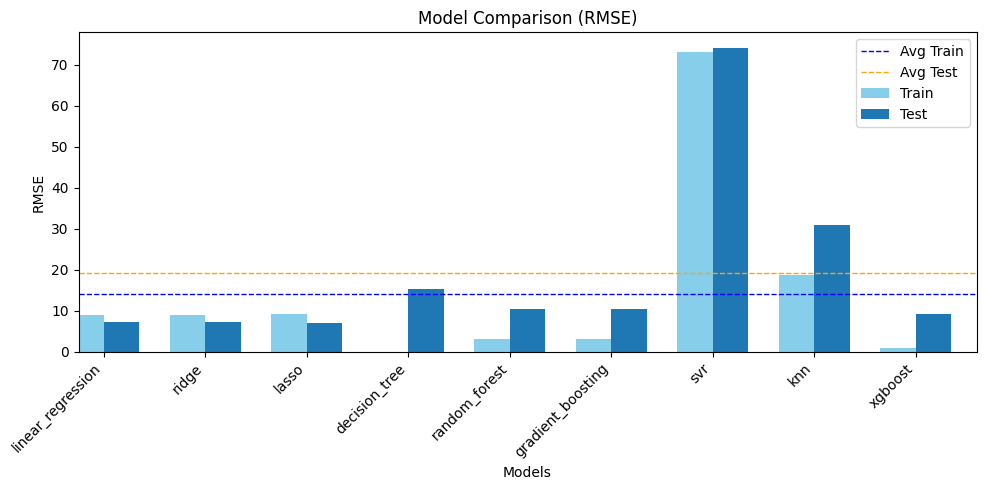

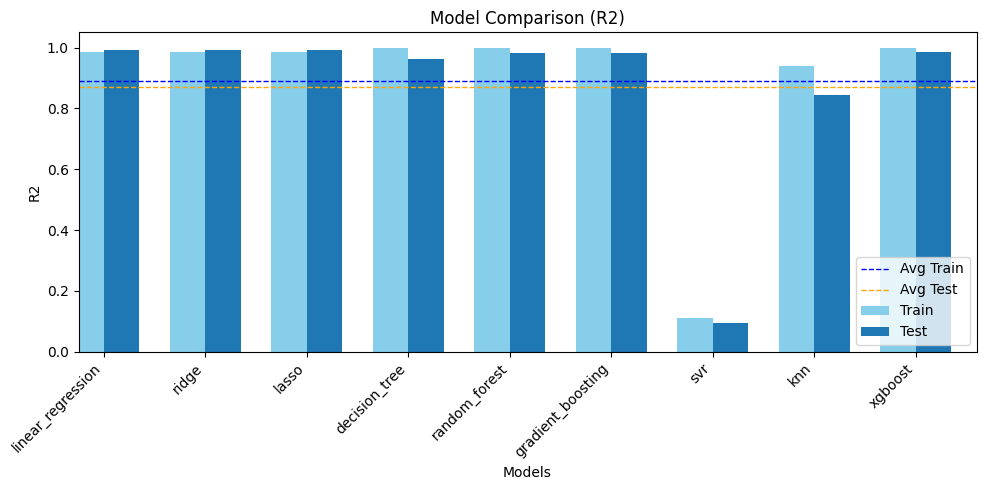

In [20]:
for metric in metrics:
    fig, ax = plt.subplots(figsize=(10, 5))
    width = 0.35

    df_train[metric].plot(
        kind="bar", ax=ax, width=width, position=1, label="Train", color="skyblue"
    )
    df_test[metric].plot(kind="bar", ax=ax, width=width, position=0, label="Test")

    avg_train = df_train[metric].mean()
    avg_test = df_test[metric].mean()

    ax.axhline(avg_train, color="blue", linestyle="--", linewidth=1, label="Avg Train")
    ax.axhline(avg_test, color="orange", linestyle="--", linewidth=1, label="Avg Test")

    ax.set_title(f"Model Comparison ({metric})")
    ax.set_ylabel(metric)
    ax.set_xlabel("Models")
    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(models, rotation=45, ha="right")

    plt.legend()
    plt.tight_layout()
    plt.show()

In [21]:
df_combined = pd.concat([df_train.add_suffix("_train"), df_test.add_suffix("_test")], axis=1)

df_combined["RMSE_diff"] = np.abs(df_combined["RMSE_train"] - df_combined["RMSE_test"])
df_combined["R2_diff"] = np.abs(df_combined["R2_train"] - df_combined["R2_test"])

overfit_threshold = 0.2
low_perf_threshold = df_combined["R2_test"].mean()

overfitting_models = df_combined[
    df_combined["R2_train"] - df_combined["R2_test"] > overfit_threshold
]

low_performance_models = df_combined[df_combined["R2_test"] < low_perf_threshold]

print(f"Modelos con overfitting: {list(overfitting_models.index)}")
print(f"Modelos con bajo desempeño: {list(low_performance_models.index)}")

Modelos con overfitting: []
Modelos con bajo desempeño: ['svr', 'knn']


In [22]:
# Modelos con rendimiento similar
similar_performance_threshold = 0.05

similar_performance_models = df_combined[(df_combined["R2_diff"] < similar_performance_threshold)]

print(
    f"Modelos con rendimiento similar en train y test: {list(similar_performance_models.index)}"
)

Modelos con rendimiento similar en train y test: ['linear_regression', 'ridge', 'lasso', 'decision_tree', 'random_forest', 'gradient_boosting', 'svr', 'xgboost']


In [23]:
overfitting_models

,RMSE_train,R2_train,RMSE_test,R2_test,RMSE_diff,R2_diff


In [24]:
low_performance_models

,RMSE_train,R2_train,RMSE_test,R2_test,RMSE_diff,R2_diff
svr,73.135467,0.109531,74.223759,0.096064,1.088292,0.013468
knn,18.837667,0.940923,30.947693,0.842852,12.110026,0.098071


In [25]:
similar_performance_models

,RMSE_train,R2_train,RMSE_test,R2_test,RMSE_diff,R2_diff
linear_regression,8.920045,0.986754,7.222551,0.991441,1.697494,0.004687
ridge,8.920045,0.986754,7.222553,0.991441,1.697492,0.004687
lasso,9.208521,0.985883,7.119881,0.991682,2.088641,0.005799
decision_tree,0.000000,1.000000,15.342904,0.961375,15.342904,0.038625
random_forest,3.105307,0.998395,10.537266,0.981782,7.431959,0.016613
gradient_boosting,3.043861,0.998458,10.415608,0.982200,7.371747,0.016258
svr,73.135467,0.109531,74.223759,0.096064,1.088292,0.013468
xgboost,0.810867,0.999891,9.272350,0.985893,8.461483,0.013997


# 📌 Análisis de Modelos Entrenados para la Predicción de Muertes por COVID-19 en NYC

## ❌ ***Modelos descartados***

Estos modelos mostraron un desempeño deficiente ya sea por **bajo poder predictivo** (underfitting) o por **alta discrepancia entre entrenamiento y prueba** (overfitting severo):

- **SVR (Support Vector Regression)**  
  - RMSE muy elevado (~73–74)  
  - R² < 0.1 tanto en entrenamiento como prueba  
  - ❗ No logra capturar la relación entre las variables.

- **KNN (K-Nearest Neighbors)**  
  - RMSE en test: ~31  
  - R² en test: 0.84  
  - ❗ Aunque generaliza un poco mejor que SVR, su error es muy alto comparado con otros modelos.


## ✅ ***Modelos Seleccionados para Validación Cruzada***

Los siguientes modelos demostraron un equilibrio adecuado entre el rendimiento en entrenamiento y en prueba, con alta capacidad predictiva:

- **Gradient Boosting Regressor**  
  - R² en test: 0.982  
  - RMSE test: ~10.41  
  - ✅ Buen equilibrio entre sesgo y varianza.

- **Random Forest Regressor**  
  - R² en test: 0.981  
  - RMSE test: ~10.53  
  - ⚠️ Leve indicio de overfitting, pero sigue siendo fuerte candidato.

- **XGBoost Regressor**  
  - R² en test: 0.986  
  - RMSE test: ~9.27  
  - ✅ Mejor desempeño general.


## 📊 ***Modelos con Rendimiento Similar pero a Descartar***

Aunque los siguientes modelos muestran **consistencia entre entrenamiento y prueba**, sus resultados no alcanzan el nivel de los modelos top:

- **Linear Regression**, **Ridge** y **Lasso**  
  - R² > 0.98 y RMSE ~7–9  
  - Aunque buenos, no superan en rendimiento a los modelos de ensamble.  
  - No capturan relaciones no lineales.

## ***Selección del modelo de validación cruzada***

In [26]:
models = {
    "random_forest": RandomForestRegressor(random_state=42),
    "gradient_boosting": GradientBoostingRegressor(random_state=42),
    "xgboost": XGBRegressor(random_state=42),
}

# Métricas de evaluación
scoring_metrics = ["neg_root_mean_squared_error", "r2"]

# KFold para validación cruzada
kfold = KFold(n_splits=10, shuffle=True, random_state=1234)

# Diccionario para almacenar los resultados de la validación cruzada
cv_results = {metric: {} for metric in scoring_metrics}

# Realizar validación cruzada para cada modelo y métrica
for model_name, model in models.items():
    model_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    for metric in scoring_metrics:
        scores = cross_val_score(model_pipe, x_train, y_train, cv=kfold, scoring=metric)
        cv_results[metric][model_name] = scores

# Convertir los resultados de la validación cruzada a DataFrames
cv_results_df = {metric: pd.DataFrame(cv_results[metric]) for metric in scoring_metrics}

In [27]:
# Crear un DataFrame combinado con los resultados de todas las métricas
mean_std_data = []

for metric_name in scoring_metrics:
    for model_name in models:
        mean_score = cv_results_df[metric_name][model_name].mean()
        std_score = cv_results_df[metric_name][model_name].std()
        mean_std_data.append(
            {
                "Model": model_name,
                "Metric": metric_name,
                "Mean": mean_score,
                "Std": std_score,
            }
        )

mean_std_df = pd.DataFrame(mean_std_data)
mean_std_df

,Model,Metric,Mean,Std
0,random_forest,neg_root_mean_squared_error,-7.879588,2.918243
1,gradient_boosting,neg_root_mean_squared_error,-6.380814,2.143022
2,xgboost,neg_root_mean_squared_error,-9.661123,4.029882
3,random_forest,r2,0.982100,0.013543
4,gradient_boosting,r2,0.987467,0.009999
5,xgboost,r2,0.974072,0.019799


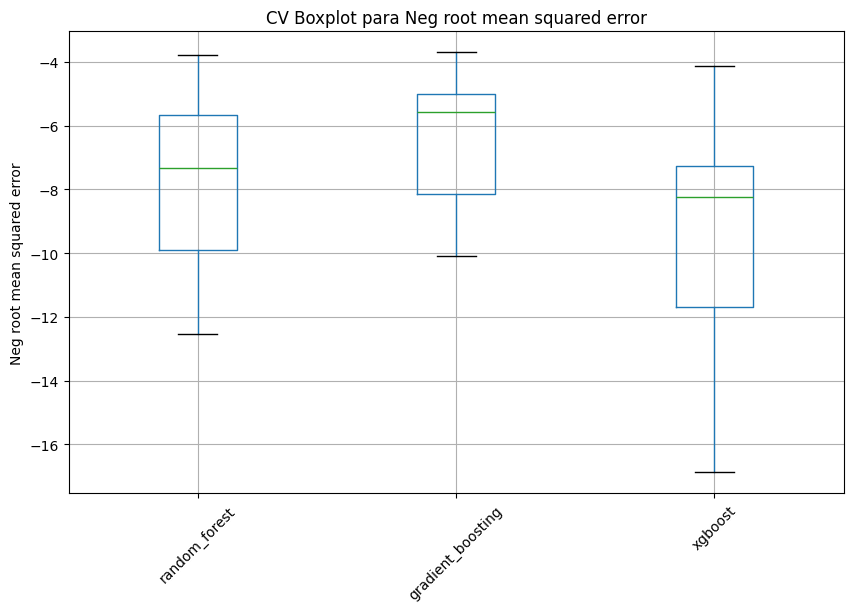

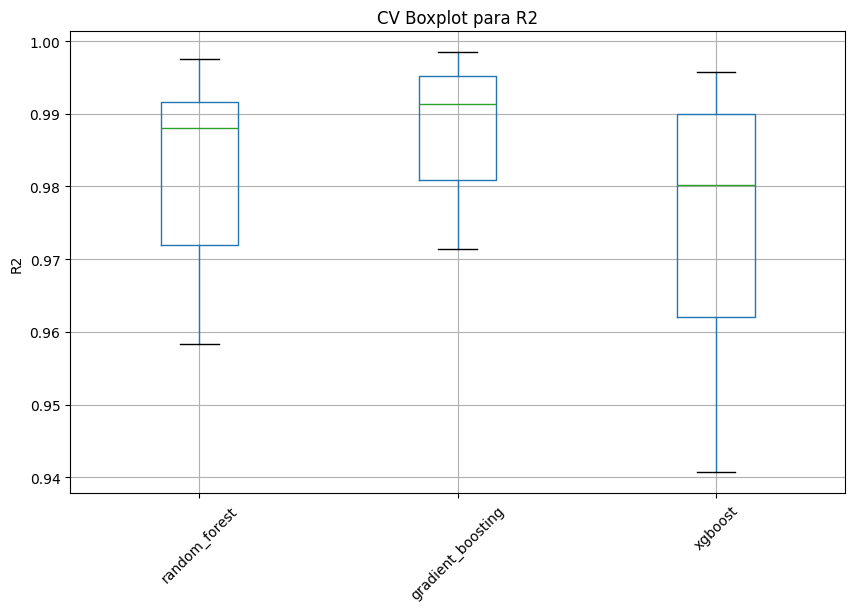

In [28]:
for metric_name in scoring_metrics:
    plt.figure(figsize=(10, 6))
    cv_results_df[metric_name].boxplot()
    plt.title(f"CV Boxplot para {metric_name.replace('_', ' ').capitalize()}")
    plt.ylabel(f"{metric_name.replace('_', ' ').capitalize()}")
    plt.xticks(rotation=45)
    plt.show()

## ***Sólo una métrica (RMSE)***

Para esta tarea de regresión, se elegirá el (RMSE) como métrica de evaluación principal. Se prefiere RMSE porque penaliza más los errores más grandes que el Error Medio Absoluto (MAE). El RMSE ayuda a identificar los modelos que no sólo minimizan los errores, sino que también garantizan predicciones coherentes y fiables.

## ***Comparación estadística de modelos***

In [29]:
result_df = cv_results_df["neg_root_mean_squared_error"]
result_df

,random_forest,gradient_boosting,xgboost
0,-11.801730,-4.774754,-16.877775
1,-7.130486,-5.845366,-8.103474
2,-8.712911,-6.298432,-8.156776
3,-10.283013,-9.012102,-11.799020
4,-7.554937,-10.094448,-11.347180
5,-3.774545,-3.704485,-4.139307
6,-5.435032,-5.027302,-5.880062
7,-6.330195,-4.986865,-8.311544
8,-12.551825,-8.758290,-14.985140
9,-5.221204,-5.306099,-7.010955


In [30]:
from scipy.stats import f_oneway

result_df = cv_results_df["neg_root_mean_squared_error"]

model1 = result_df["random_forest"]
model2 = result_df["gradient_boosting"]
model3 = result_df["xgboost"]

# ANOVA para comparar los modelos
statistic, p_value = f_oneway(model1, model2, model3)

print(f"Statistic: {statistic}")
print(f"p_value: {p_value}")

alpha = 0.05

if p_value < alpha:
    print(
        "Hay una diferencia estadísticamente significativa "
        "en los resultados RMSE de validación cruzada de los modelos"
    )
else:
    print(
        "NO hay una diferencia estadísticamente significativa "
        "en los resultados RMSE de validación cruzada de los modelos"
    )

Statistic: 2.756621547534746
p_value: 0.08139484213135886
NO hay una diferencia estadísticamente significativa en los resultados RMSE de validación cruzada de los modelos


Estadísticamente todos los modelos son similares, por lo que se seleccionan dos modelos para afinarlos en el siguiente paso:

✅ **Gradient Boosting** → Mejor RMSE, buen rendimiento general.

✅ **XGBoost** → Tiempo de entrenamiento más rápido, RMSE similar a Random Forest.

## ***Hyperparameter tunning***

In [31]:
from sklearn.model_selection import GridSearchCV

### ***Gradient Boosting***

In [32]:
score = "neg_root_mean_squared_error"

# Hyperparameter tuning
gb_params = {
    "model__n_estimators": [100, 300, 500],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__max_depth": [3, 5, 7],
}

gb_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", GradientBoostingRegressor())])

grid_search_gb = GridSearchCV(
    gb_pipe, gb_params, cv=5, scoring=score, return_train_score=True, n_jobs=-1
)
grid_search_gb.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['CASE_COUNT',
                                                                          'PROBABLE_CASE_COUNT',
                                                                          'HOSPITALIZED_COUNT',
                                                                          'CASE_COUNT_7DAY_AVG',
                                                                          'ALL_CASE_COUNT_7DAY_AVG',
                                                                          'HOSP_COUNT_7DAY_AVG',
                                                                          'DEATH_COUNT_7DAY_AVG'])])),
                                       ('model', GradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_depth': [3, 5, 7],
                         'model__n_estimators': [100, 300, 500]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [33]:
print("Mejores parámetros para Gradient Boosting:", grid_search_gb.best_params_)

Mejores parámetros para Gradient Boosting: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}


***Evaluation Gradient Boosting***

In [34]:
best_gb_model = GradientBoostingRegressor(
    learning_rate=0.01, max_depth=5, n_estimators=500, random_state=42
)

gb_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", best_gb_model)])
gb_final_model = gb_pipe.fit(x_train, y_train)

### ***XGBoost***

In [35]:
# Hyperparameter tuning
xgb_params = {
    "model__n_estimators": [100, 300, 500],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__max_depth": [3, 5, 7],
}

xgb_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", XGBRegressor(objective="reg:squarederror", random_state=42)),
    ]
)

grid_search_xgb = GridSearchCV(
    xgb_pipe, xgb_params, cv=5, scoring=score, return_train_score=True, n_jobs=-1
)
grid_search_xgb.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['CASE_COUNT',
                                                                          'PROBABLE_CASE_COUNT',
                                                                          'HOSPITALIZED_COUNT',
                                                                          'CASE_COUNT_7DAY_AVG',
                                                                          'ALL_CASE_COUNT_7DAY_AVG',
                                                                          'HOSP_COUNT_7DAY_AVG',
                                                                          'DEATH_COUNT_7DAY_AVG'])])),
                                       ('model',
                                        XGBRegressor(base_sc...
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_depth': [3, 5, 7],
                         'model__n_estimators': [100, 300, 500]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [36]:
print("Mejores parámetros para XGBoost:", grid_search_xgb.best_params_)

Mejores parámetros para XGBoost: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}


***Evaluation XGBoost***

In [37]:
best_xgb_model = XGBRegressor(
    learning_rate=0.1, max_depth=5, n_estimators=100, objective="reg:squarederror", random_state=42
)

xgb_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", best_xgb_model)])
xgb_final_model = xgb_pipe.fit(x_train, y_train)

## ***Final Evaluation Test***

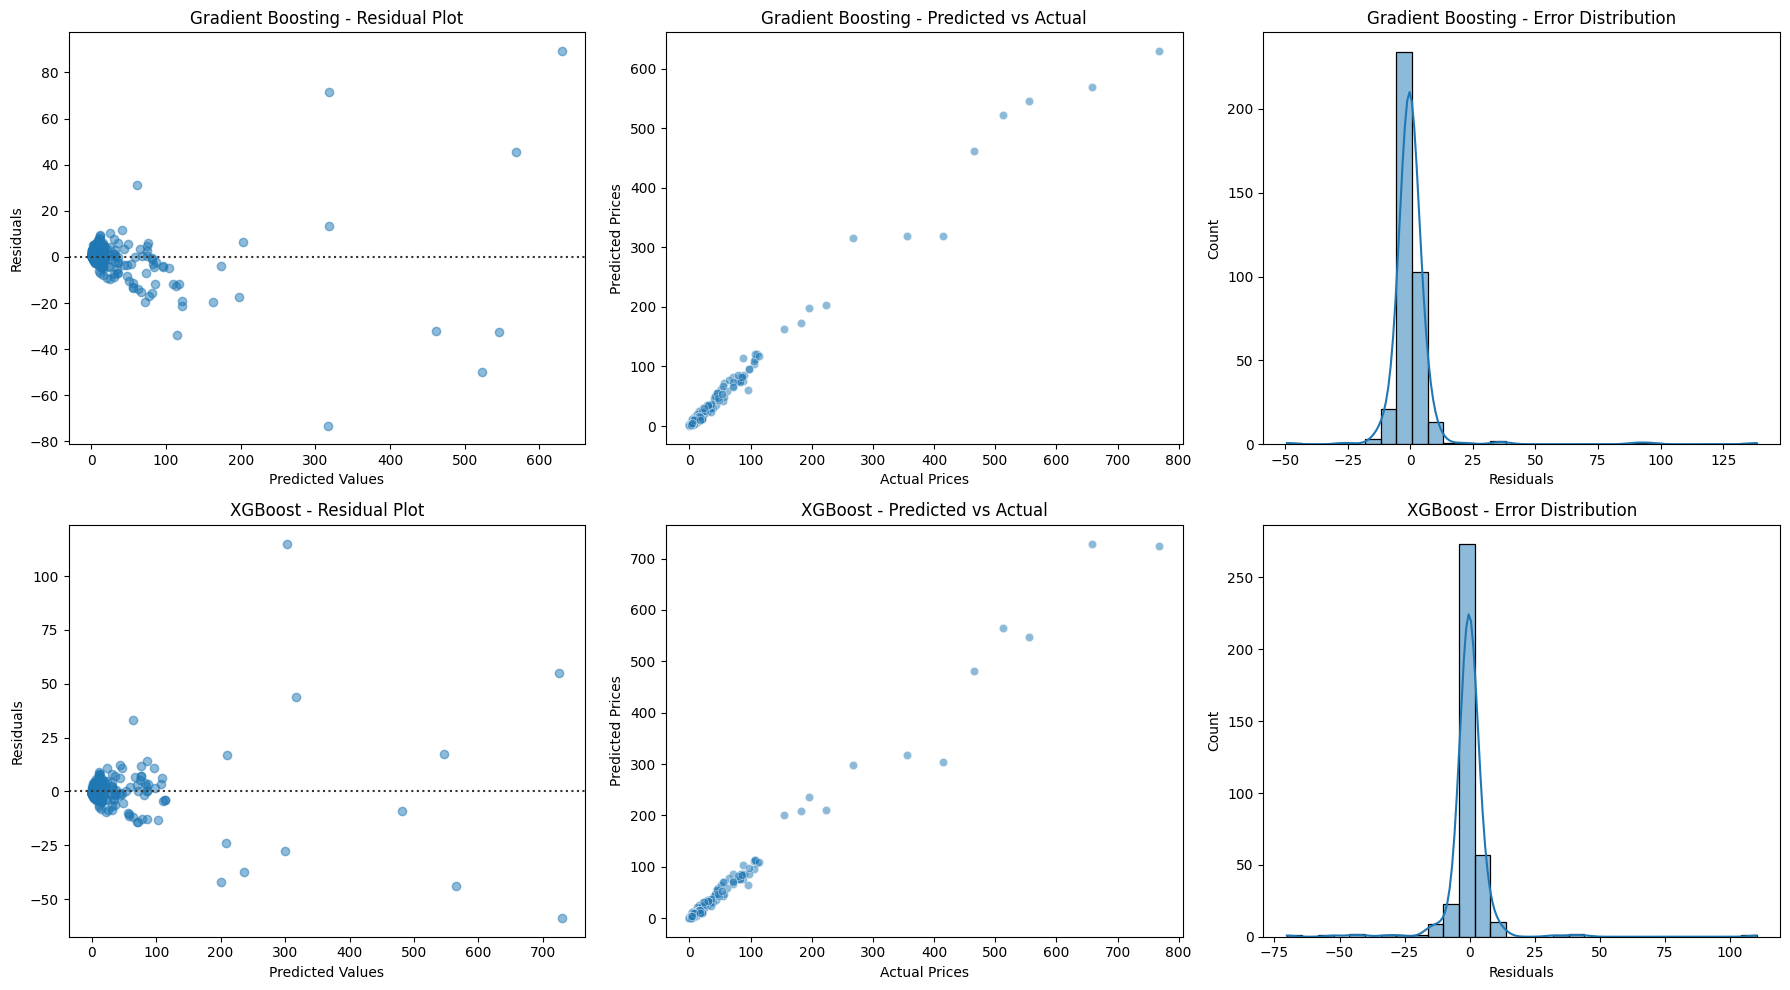

In [38]:
import seaborn as sns

# Predicciones
y_pred_gb = gb_final_model.predict(x_test)
y_pred_xgb = xgb_final_model.predict(x_test)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Residual Plot
sns.residplot(
    x=y_pred_gb, y=(y_test - y_pred_gb), ax=axes[0, 0], scatter_kws={"alpha": 0.5}
)
axes[0, 0].set_title("Gradient Boosting - Residual Plot")
axes[0, 0].set_xlabel("Predicted Values")
axes[0, 0].set_ylabel("Residuals")

sns.residplot(
    x=y_pred_xgb, y=(y_test - y_pred_xgb), ax=axes[1, 0], scatter_kws={"alpha": 0.5}
)
axes[1, 0].set_title("XGBoost - Residual Plot")
axes[1, 0].set_xlabel("Predicted Values")
axes[1, 0].set_ylabel("Residuals")

# Predicted vs Actual Values
sns.scatterplot(x=y_test, y=y_pred_gb, ax=axes[0, 1], alpha=0.5)
axes[0, 1].set_title("Gradient Boosting - Predicted vs Actual")
axes[0, 1].set_xlabel("Actual Prices")
axes[0, 1].set_ylabel("Predicted Prices")

sns.scatterplot(x=y_test, y=y_pred_xgb, ax=axes[1, 1], alpha=0.5)
axes[1, 1].set_title("XGBoost - Predicted vs Actual")
axes[1, 1].set_xlabel("Actual Prices")
axes[1, 1].set_ylabel("Predicted Prices")

# Error Distribution
sns.histplot(y_test - y_pred_gb, kde=True, bins=30, ax=axes[0, 2])
axes[0, 2].set_title("Gradient Boosting - Error Distribution")
axes[0, 2].set_xlabel("Residuals")

sns.histplot(y_test - y_pred_xgb, kde=True, bins=30, ax=axes[1, 2])
axes[1, 2].set_title("XGBoost - Error Distribution")
axes[1, 2].set_xlabel("Residuals")

plt.tight_layout()
plt.show()

### ***Model comparison***

Ambos modelos muestran un rendimiento **muy similar** tanto en el RMSE como en la distribución de errores. Sin embargo, al observar las gráficas detalladamente:

- XGBoost muestra una mejor distribución de errores
- Tiene una estructura más eficiente (menos estimadores, mayor learning rate)

✅ **Se selecciona `XGBoost` como el modelo final** para este dataset de predicción de muertes por COVID-19 en NYC.

## ***Curva de aprendizaje XGBoost***

Esta curva se utiliza para ver si el modelo se ajusta demasiado o demasiado poco.

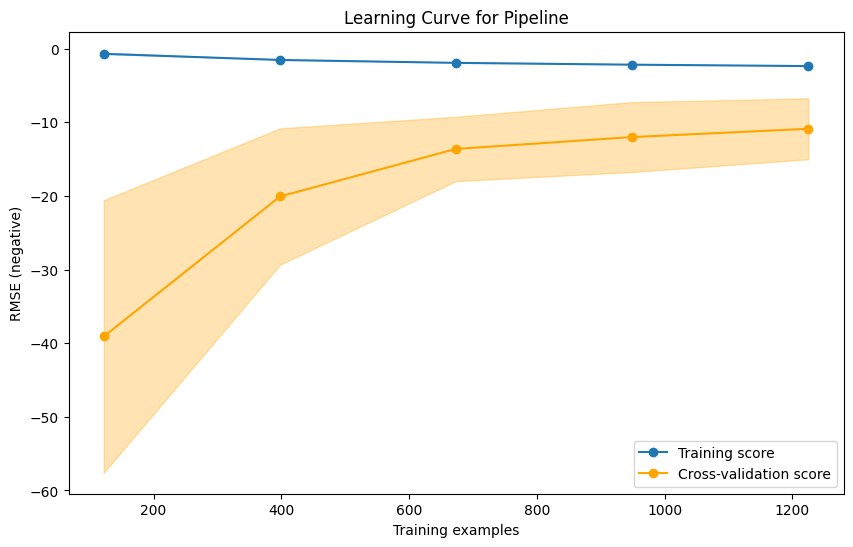

Training Sizes: [ 122  398  673  949 1225]
Training Scores Mean: [-0.69502791 -1.52683735 -1.92135571 -2.16769245 -2.356336  ]
Training Scores Std: [0.1519083  0.07510662 0.06493121 0.07196585 0.05982047]
Test Scores Mean: [-39.09040501 -20.07182809 -13.61624201 -12.00242487 -10.87665257]
Test Scores Std: [18.50801005  9.26097889  4.3715818   4.75216092  4.13957058]


In [39]:
model = xgb_final_model

common_params = {
    "X": x_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=123),
    "n_jobs": -1,
    "return_times": True,
}

scoring_metric = "neg_root_mean_squared_error"

train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
    model, **common_params, scoring=scoring_metric
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)
score_times_mean = np.mean(score_times, axis=1)
score_times_std = np.std(score_times, axis=1)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train_sizes, train_mean, "o-", label="Training score")
ax.plot(train_sizes, test_mean, "o-", color="orange", label="Cross-validation score")
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.3)
ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.3, color="orange")

ax.set_title(f"Learning Curve for {model.__class__.__name__}")
ax.set_xlabel("Training examples")
ax.set_ylabel("RMSE (negative)")
ax.legend(loc="best")

plt.show()

print("Training Sizes:", train_sizes)
print("Training Scores Mean:", train_mean)
print("Training Scores Std:", train_std)
print("Test Scores Mean:", test_mean)
print("Test Scores Std:", test_std)

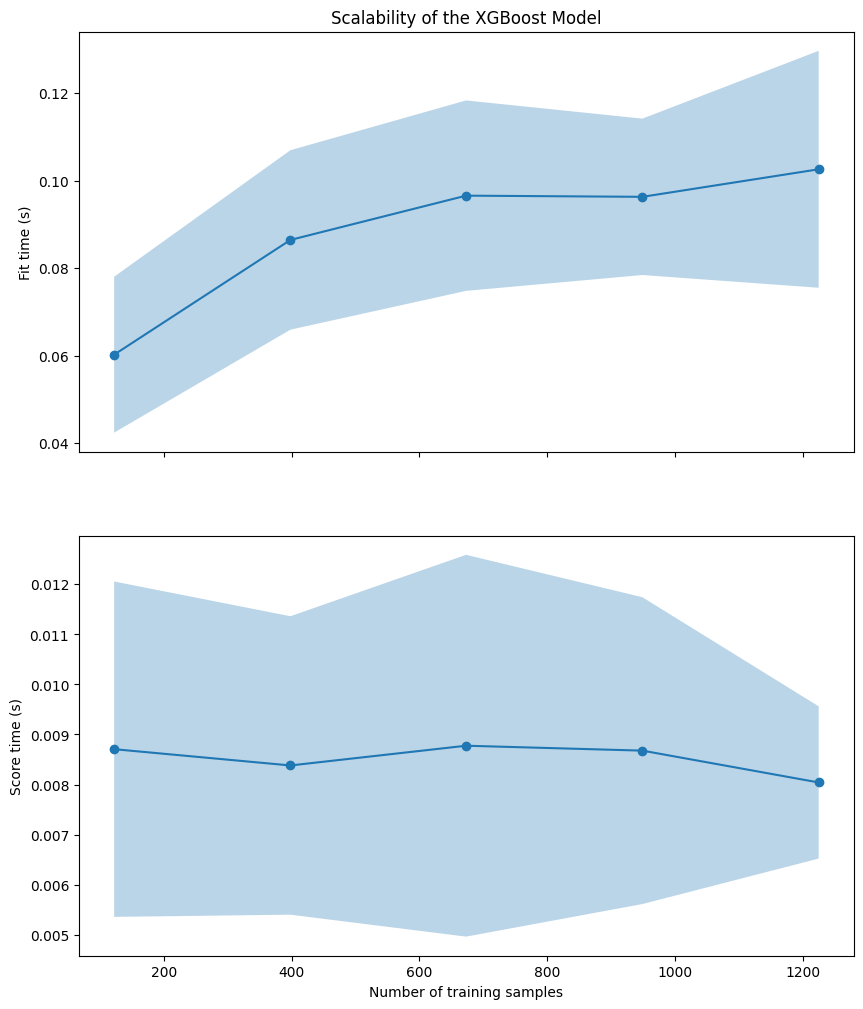

Fit Times Mean: [0.06019706 0.08643422 0.09656058 0.09629147 0.10258865]
Fit Times Std: [0.01782414 0.02051902 0.02177488 0.01788012 0.02708946]
Score Times Mean: [0.00870622 0.00838105 0.00877537 0.00867735 0.00804122]
Score Times Std: [0.00335104 0.00298229 0.00381495 0.00306592 0.00152131]


In [40]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 12), sharex=True)

ax[0].plot(train_sizes, fit_times_mean, "o-")
ax[0].fill_between(
    train_sizes,
    fit_times_mean - fit_times_std,
    fit_times_mean + fit_times_std,
    alpha=0.3,
)
ax[0].set_ylabel("Fit time (s)")
ax[0].set_title("Scalability of the XGBoost Model")

ax[1].plot(train_sizes, score_times_mean, "o-")
ax[1].fill_between(
    train_sizes,
    score_times_mean - score_times_std,
    score_times_mean + score_times_std,
    alpha=0.3,
)
ax[1].set_ylabel("Score time (s)")
ax[1].set_xlabel("Number of training samples")

plt.show()

print("Fit Times Mean:", fit_times_mean)
print("Fit Times Std:", fit_times_std)
print("Score Times Mean:", score_times_mean)
print("Score Times Std:", score_times_std)

# 💾 ***Save the model***

In [41]:
from joblib import dump

dump(xgb_final_model, "../../models/covid_regression-xgboost-v1.joblib")

['../../models/covid_regression-xgboost-v1.joblib']

## ***Probar el modelo guardado***

In [57]:
from joblib import load

my_model = load("../../models/covid_regression-xgboost-v1.joblib")

df_test = x_test.sample(10)
df_test

,CASE_COUNT,PROBABLE_CASE_COUNT,HOSPITALIZED_COUNT,CASE_COUNT_7DAY_AVG,ALL_CASE_COUNT_7DAY_AVG,HOSP_COUNT_7DAY_AVG,DEATH_COUNT_7DAY_AVG
1502,138,75,27,131,208,19,3
1305,1100,534,84,928,1420,82,4
1329,427,163,66,442,658,55,4
266,1290,354,119,1590,2077,118,11
69,1079,25,166,1231,1260,205,185
261,1832,526,127,1412,1892,97,10
1701,62,35,13,110,174,16,1
1444,687,313,83,547,830,75,5
782,1996,401,60,1856,2240,53,4
1078,544,171,72,983,1254,93,14


In [58]:
predictions = my_model.predict(df_test)
predictions = predictions.astype(int)
print("Predictions for first test samples:", predictions)

Predictions for first test samples: [  2   4   3  10 200  10   0   4   4  13]


In [59]:
df_test["DEATH_COUNT"] = predictions
df_test

,CASE_COUNT,PROBABLE_CASE_COUNT,HOSPITALIZED_COUNT,CASE_COUNT_7DAY_AVG,ALL_CASE_COUNT_7DAY_AVG,HOSP_COUNT_7DAY_AVG,DEATH_COUNT_7DAY_AVG,DEATH_COUNT
1502,138,75,27,131,208,19,3,2
1305,1100,534,84,928,1420,82,4,4
1329,427,163,66,442,658,55,4,3
266,1290,354,119,1590,2077,118,11,10
69,1079,25,166,1231,1260,205,185,200
261,1832,526,127,1412,1892,97,10,10
1701,62,35,13,110,174,16,1,0
1444,687,313,83,547,830,75,5,4
782,1996,401,60,1856,2240,53,4,4
1078,544,171,72,983,1254,93,14,13


# 📊 ***Análisis del Modelo XGBoost***

## 📈 Curva de Aprendizaje

Los resultados de la curva de aprendizaje muestran que:

- El RMSE de validación es considerablemente mayor, pero **mejora constantemente** conforme se entrena con más datos.
- La brecha entre entrenamiento y validación **se reduce** gradualmente, lo que sugiere que el modelo **generaliza mejor** con más datos.
- No hay signos de sobreajuste agresivo. Más bien, el modelo muestra signos leves de **subajuste (underfitting)** inicial, que se corrige con más ejemplos.

## 🧪 Recomendaciones

1️⃣ **Continuar con el modelo XGBoost**

- Es eficiente, escalable y mejora consistentemente con más datos.
- Ideal para despliegue o futuras optimizaciones.

2️⃣ **Incorporar más datos si es posible**

- La curva no se aplana completamente, lo que sugiere que más datos podrían **reducir aún más el error**.

## 🚀 Conclusión Final

✅ El modelo **XGBoost** es el mejor candidato para esta tarea de regresión sobre muertes por COVID-19.

- Su rendimiento mejora de forma consistente con más datos.
- Presenta **buen equilibrio entre precisión y eficiencia computacional**.